# Installs & Imports

In [1]:
!pip install -q dask[dataframe] kaggle cma catboost category_encoders deap optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.5/283.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.7 MB/s eta 0:00:00


In [2]:
import os
import zipfile
import shutil
import random
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score,
    make_scorer
)
from sklearn.base import clone

import joblib
from joblib import Parallel, delayed
import multiprocessing
from tqdm.notebook import tqdm

import cma
from cma import CMAEvolutionStrategy, ScaleCoordinates

import xgboost
import lightgbm
import catboost

from category_encoders import TargetEncoder

import optuna
from optuna.exceptions import TrialPruned
from optuna.samplers import TPESampler

from deap import base, creator, tools, algorithms

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Display all columns
pd.set_option('display.max_columns', None)

# Load the Data

In [3]:
def download_and_load_dataset():
    """
    Download and extract the 'aswathrao/demand-forecasting' dataset from Kaggle.
    Load the 'train.csv' into a pandas DataFrame named 'df'.

    Returns:
    - df (pd.DataFrame): Loaded DataFrame.
    """
    dataset_name = "aswathrao/demand-forecasting"

    # Download the dataset
    print("Downloading the dataset from Kaggle...")
    !kaggle datasets download -d {dataset_name} -p /content

    # Unzip the dataset into a folder named 'demand-forecasting'
    zip_path = '/content/demand-forecasting.zip'
    extract_to = '/content/demand-forecasting'
    print("Extracting the dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    # Remove the zip file to save space
    os.remove(zip_path)

    # Iterate through the files in the dataset directory to find 'train.csv'
    for filename in os.listdir(extract_to):
        if 'train' in filename.lower() and filename.endswith('.csv'):
            original_path = os.path.join(extract_to, filename)
            new_path = '/content/train.csv'
            shutil.move(original_path, new_path)
            print(f"Renamed '{filename}' to 'train.csv'")
            break
    else:
        print("No file with 'train' found in the dataset directory.")
        return None

    # Load the train.csv into a pandas DataFrame
    print("Loading 'train.csv' into a DataFrame...")
    df = pd.read_csv('/content/train.csv')

    # Display the first few rows of the DataFrame
    print("\nFirst 5 rows of train.csv:")
    display(df.head())

    # Display the last few rows of the DataFrame
    print("\nLast 5 rows of train.csv:")
    display(df.tail())

    return df

In [4]:
# Download, extract, and load the dataset
df = download_and_load_dataset()

Dataset URL: https://www.kaggle.com/datasets/aswathrao/demand-forecasting
License(s): unknown
  0% 0.00/1.50M [00:00<?, ?B/s]
100% 1.50M/1.50M [00:00<00:00, 133MB/s]
Extracting the dataset...
Renamed 'train_0irEZ2H.csv' to 'train.csv'
Loading 'train.csv' into a DataFrame...

First 5 rows of train.csv:


,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52



Last 5 rows of train.csv:


,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
150145,212638,09/07/13,9984,223245,235.8375,235.8375,0,0,38
150146,212639,09/07/13,9984,223153,235.8375,235.8375,0,0,30
150147,212642,09/07/13,9984,245338,357.6750,483.7875,1,1,31
150148,212643,09/07/13,9984,547934,141.7875,191.6625,0,1,12
150149,212644,09/07/13,9984,679023,234.4125,234.4125,0,0,15


# Explore the Data

In [5]:
def clean_and_engineer_date_features(df):
    """
    Clean the 'week' variable by converting it to datetime and extracting day, month, year.

    Parameters:
    - df (pd.DataFrame): The DataFrame to clean and engineer features on.

    Returns:
    - df (pd.DataFrame): DataFrame with new date features.
    """
    # Inspect the 'week' variable
    print("===== 'week' Variable Before Cleaning =====")
    display(df['week'].head())

    # Convert 'week' to datetime
    try:
        df['date'] = pd.to_datetime(df['week'], format='%d/%m/%y')
    except Exception as e:
        print(f"Error converting 'week' to datetime: {e}")
        print("Please verify the format of the 'week' column.")
        return df

    # Extract day, month, year, week_of_year, day_of_week
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6

    # Create flags for start and end of year
    df['is_start_of_year'] = df['week_of_year'].apply(lambda x: 1 if x <= 4 else 0)
    df['is_end_of_year'] = df['week_of_year'].apply(lambda x: 1 if x >= 48 else 0)

    # Create 'week_of_month' feature
    def get_week_of_month(date):
        """
        Calculate the week of the month for a given date.

        Parameters:
        - date (pd.Timestamp): The date for which to calculate the week of the month.

        Returns:
        - int: The week of the month (1-based index).
        """
        first_day = date.replace(day=1)
        dom = date.day
        # Adjust the day of month by adding the weekday of the first day
        adjusted_dom = dom + first_day.weekday()
        # Calculate week number
        return int(np.ceil(adjusted_dom / 7.0))

    df['week_of_month'] = df['date'].apply(get_week_of_month)

    # Drop the original 'week' column as it's now redundant
    df = df.drop(['week'], axis=1)

    # Categorize variables
    categorical_cols = ['record_ID', 'store_id', 'sku_id', 'is_featured_sku', 'is_display_sku']

    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")

    # Display data types after conversion
    print("\n===== Data Types After Date Engineering =====")
    display(df.dtypes)

    print("\n")
    display(df.head())

    return df

In [6]:
# Execute the function
df = clean_and_engineer_date_features(df)

===== 'week' Variable Before Cleaning =====


,week
0,17/01/11
1,17/01/11
2,17/01/11
3,17/01/11
4,17/01/11



===== Data Types After Date Engineering =====


,0
record_ID,category
store_id,category
sku_id,category
total_price,float64
base_price,float64
is_featured_sku,category
is_display_sku,category
units_sold,int64
date,datetime64[ns]
day,int32


,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,date,day,month,year,week_of_year,day_of_week,is_start_of_year,is_end_of_year,week_of_month
0,1,8091,216418,99.0375,111.8625,0,0,20,2011-01-17,17,1,2011,3,0,1,0,4
1,2,8091,216419,99.0375,99.0375,0,0,28,2011-01-17,17,1,2011,3,0,1,0,4
2,3,8091,216425,133.9500,133.9500,0,0,19,2011-01-17,17,1,2011,3,0,1,0,4
3,4,8091,216233,133.9500,133.9500,0,0,44,2011-01-17,17,1,2011,3,0,1,0,4
4,5,8091,217390,141.0750,141.0750,0,0,52,2011-01-17,17,1,2011,3,0,1,0,4


In [7]:
def count_unique_dates(df):
    """
    Counts the number of unique dates associated with each store_id and each sku_id.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data with 'store_id', 'sku_id', and 'date' columns.

    Returns:
    - store_unique_dates (pd.DataFrame): DataFrame with 'store_id' and 'unique_dates_count'.
    - sku_unique_dates (pd.DataFrame): DataFrame with 'sku_id' and 'unique_dates_count'.
    """
    # Required columns
    required_cols = ['store_id', 'sku_id', 'date']

    # Check if all required columns are present
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"The following required columns are missing from the DataFrame: {missing_cols}")

    # Ensure 'date' column is of datetime type
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        if df['date'].isnull().any():
            raise ValueError("Some dates could not be converted to datetime. Please check the 'date' column.")

    # Number of unique dates per store_id
    store_unique_dates = (
        df.groupby('store_id')['date']
        .nunique()
        .reset_index()
        .rename(columns={'date': 'unique_dates_count'})
        .sort_values(by='unique_dates_count', ascending=False)
    )

    # Number of unique dates per sku_id
    sku_unique_dates = (
        df.groupby('sku_id')['date']
        .nunique()
        .reset_index()
        .rename(columns={'date': 'unique_dates_count'})
        .sort_values(by='unique_dates_count', ascending=False)
    )

    return store_unique_dates, sku_unique_dates

In [8]:
# Check unique dates per 'store_id' and 'sku_id'
store_unique_dates_df, sku_unique_dates_df = count_unique_dates(df)

# Display the number of unique dates per store_id
print("Unique Dates per Store ID:")
display(store_unique_dates_df)

# Display the number of unique dates per sku_id
print("\nUnique Dates per SKU ID:")
display(sku_unique_dates_df)

Unique Dates per Store ID:


,store_id,unique_dates_count
0,8023,130
48,9532,130
55,9700,130
54,9680,130
53,9672,130
...,...,...
24,9112,130
23,9092,130
22,9043,130
21,9001,130



Unique Dates per SKU ID:


,sku_id,unique_dates_count
0,216233,130
1,216418,130
26,673209,130
25,600934,130
24,547934,130
23,546789,130
22,545621,130
21,398721,130
20,378934,130
19,327492,130


In [9]:
def explore_data(df, top_n=10):
    """
    Perform comprehensive exploratory data analysis on the DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame to explore.
    - top_n (int): Number of top items to display in bar plot.
    """
    # Set plot styles for consistency and aesthetics
    sns.set(style='whitegrid')
    plt.rcParams['figure.figsize'] = (6, 4)
    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8

    # 1. Basic Information
    print("===== Basic Information =====")
    df.info()
    print("\n")

    # 2. Descriptive Statistics for Numerical Features
    numerical_features = ['total_price', 'base_price', 'units_sold']
    print("===== Descriptive Statistics (Numerical Features) =====")
    if all(feature in df.columns for feature in numerical_features):
        display(df[numerical_features].describe())
    else:
        missing_feats = [feat for feat in numerical_features if feat not in df.columns]
        print(f"Missing numerical features: {missing_feats}")
    print("\n")

    # 3. Descriptive Statistics for Categorical Features
    categorical_features = ['record_ID', 'store_id', 'sku_id', 'is_featured_sku', 'is_display_sku']
    print("===== Descriptive Statistics (Categorical Features) =====")
    if all(feature in df.columns for feature in categorical_features):
        display(df[categorical_features].describe())
    else:
        missing_feats = [feat for feat in categorical_features if feat not in df.columns]
        print(f"Missing categorical features: {missing_feats}")
    print("\n")

    # 4. Number of Missing Values per Column
    print("===== Number of Missing Values per Column =====")
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    if not missing_values.empty:
        display(missing_values)
    else:
        print("No missing values detected.")
    print("\n")

    # 5. Histograms for Numerical Features
    print("===== Histograms for Numerical Features =====")
    for col in numerical_features:
        if col in df.columns:
            plt.figure()
            sns.histplot(df[col].dropna(), kde=True, bins=30, color='skyblue')
            plt.title(f'Histogram of {col}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
            plt.show()
        else:
            print(f"Column '{col}' not found in DataFrame.")
    print("\n")

    # 6. Boxplots for Numerical Features
    print("===== Boxplots for Numerical Features =====")
    for col in numerical_features:
        if col in df.columns:
            plt.figure()
            sns.boxplot(x=df[col], color='lightgreen')
            plt.title(f'Boxplot of {col}')
            plt.xlabel(col)
            plt.show()
        else:
            print(f"Column '{col}' not found in DataFrame.")
    print("\n")

    # 7. Correlation Heatmap for Numerical Features
    print("===== Correlation Heatmap (Numerical Features) =====")
    if all(feature in df.columns for feature in numerical_features):
        corr_matrix = df[numerical_features].corr()
        plt.figure(figsize=(6, 4))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Heatmap of Numerical Features')
        plt.show()
    else:
        missing_feats = [feat for feat in numerical_features if feat not in df.columns]
        print(f"Cannot generate heatmap. Missing numerical features: {missing_feats}")
    print("\n")

    # 8. Unique Values for Categorical and Time-based Variables
    unique_features = ['record_ID', 'store_id', 'sku_id', 'is_featured_sku', 'is_display_sku',
                       'day', 'month', 'year', 'week_of_year', 'day_of_week',
                       'is_start_of_year', 'is_end_of_year', 'week_of_month']
    print("===== Unique Values for Categorical and Time-based Variables =====")
    for col in unique_features:
        if col in df.columns:
            unique_count = df[col].nunique()
            print(f"'{col}': {unique_count} unique values")
        else:
            print(f"Column '{col}' not found in DataFrame.")
    print("\n")

    # 9. Boxplot of 'units_sold' by 'day', 'month', and 'year'
    print("===== Boxplot of 'units_sold' by Time-based Features =====")
    time_based_features = ['day', 'month', 'year']
    for time_col in time_based_features:
        if time_col in df.columns and 'units_sold' in df.columns:
            plt.figure(figsize=(6, 4))
            sns.boxplot(x=df[time_col], y=df['units_sold'], palette='viridis')
            plt.title(f'Units Sold by {time_col.capitalize()}')
            plt.xlabel(time_col.capitalize())
            plt.ylabel('Units Sold')
            plt.show()
        else:
            print(f"Cannot plot boxplot for '{time_col}'. Column not found in DataFrame.")
    print("\n")

    # 10. Bar Plot of Total Units Sold per Month
    print("===== Bar Plot of Total Units Sold per Month =====")
    if 'month' in df.columns and 'units_sold' in df.columns:
        units_per_month = df.groupby('month')['units_sold'].sum().reset_index()
        # Ensure months are sorted correctly
        units_per_month = units_per_month.sort_values('month')
        plt.figure(figsize=(6, 4))
        sns.barplot(x='month', y='units_sold', data=units_per_month, palette='Blues_d')
        plt.title('Total Units Sold per Month')
        plt.xlabel('Month')
        plt.ylabel('Total Units Sold')
        plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        plt.show()
    else:
        print("Columns 'month' and/or 'units_sold' not found in DataFrame.")
    print("\n")

    # 11. Bar Plot of Total Units Sold per Year
    print("===== Bar Plot of Total Units Sold per Year =====")
    if 'year' in df.columns and 'units_sold' in df.columns:
        units_per_year = df.groupby('year')['units_sold'].sum().reset_index()
        units_per_year = units_per_year.sort_values('year')
        plt.figure(figsize=(6, 4))
        sns.barplot(x='year', y='units_sold', data=units_per_year, palette='Greens_d')
        plt.title('Total Units Sold per Year')
        plt.xlabel('Year')
        plt.ylabel('Total Units Sold')
        plt.show()
    else:
        print("Columns 'year' and/or 'units_sold' not found in DataFrame.")
    print("\n")

    # 12. Bar Plot of Total Units Sold by Item (sku_id) for Each Year
    print("===== Bar Plot of Total Units Sold by Item (sku_id) for Each Year =====")
    if 'year' in df.columns and 'sku_id' in df.columns and 'units_sold' in df.columns:
        # Aggregate units sold by sku_id and year
        units_sold_by_item_year = df.groupby(['year', 'sku_id'])['units_sold'].sum().reset_index()

        # To prevent the plot from being too cluttered, select top N items per year
        top_items_per_year = units_sold_by_item_year.groupby('year') \
                                .apply(lambda x: x.nlargest(top_n, 'units_sold')) \
                                .reset_index(drop=True)

        # Sort the data for each year by units_sold descending
        top_items_per_year = top_items_per_year.sort_values(['year', 'units_sold'], ascending=[True, False])

        # Get unique years sorted
        unique_years = sorted(top_items_per_year['year'].unique())
        n_years = len(unique_years)

        # Define the layout for subplots
        cols = 3  # Number of columns in the subplot grid
        rows = (n_years + cols - 1) // cols  # Calculate the number of rows needed

        # Set a larger figure size to accommodate all subplots
        plt.figure(figsize=(cols * 6, rows * 5))

        # Create individual bar plots for each year
        for idx, year in enumerate(unique_years):
            plt.subplot(rows, cols, idx + 1)
            data = top_items_per_year[top_items_per_year['year'] == year].copy()
            # Ensure 'sku_id' is treated as string
            data['sku_id'] = data['sku_id'].astype(str)
            # Sort the data descending by units_sold
            data = data.sort_values('units_sold', ascending=False)
            # Create bar plot with sorted SKU IDs
            sns.barplot(x='sku_id', y='units_sold', data=data, palette='magma', order=data['sku_id'])
            plt.title(f'Year: {year}')
            plt.xlabel('SKU ID')
            plt.ylabel('Total Units Sold')
            plt.ylim(0, data['units_sold'].max() * 1.1)  # Adjust the y-axis limits
            plt.xticks(rotation=45)
            # Annotate bars with units_sold
            for p in plt.gca().patches:
                plt.gca().annotate(format(p.get_height(), '.0f'),
                                   (p.get_x() + p.get_width() / 2., p.get_height()),
                                   ha='center', va='bottom', xytext=(0, 5),
                                   textcoords='offset points', fontsize=8)

        # Remove any empty subplots
        total_plots = rows * cols
        if n_years < total_plots:
            for empty_idx in range(n_years, total_plots):
                plt.subplot(rows, cols, empty_idx + 1).axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("Columns 'year', 'sku_id', and/or 'units_sold' not found in DataFrame.")
    print("\n")

    print("===== Data Exploration Completed =====")

===== Basic Information =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   record_ID         150150 non-null  category      
 1   store_id          150150 non-null  category      
 2   sku_id            150150 non-null  category      
 3   total_price       150149 non-null  float64       
 4   base_price        150150 non-null  float64       
 5   is_featured_sku   150150 non-null  category      
 6   is_display_sku    150150 non-null  category      
 7   units_sold        150150 non-null  int64         
 8   date              150150 non-null  datetime64[ns]
 9   day               150150 non-null  int32         
 10  month             150150 non-null  int32         
 11  year              150150 non-null  int32         
 12  week_of_year      150150 non-null  int64         
 13  day_of_week       150150 non-

,total_price,base_price,units_sold
count,150149.000000,150150.000000,150150.000000
mean,206.626751,219.425927,51.674206
std,103.308516,110.961712,60.207904
min,41.325000,61.275000,1.000000
25%,130.387500,133.237500,20.000000
50%,198.075000,205.912500,35.000000
75%,233.700000,234.412500,62.000000
max,562.162500,562.162500,2876.000000




===== Descriptive Statistics (Categorical Features) =====


,record_ID,store_id,sku_id,is_featured_sku,is_display_sku
count,150150,150150,150150,150150,150150
unique,150150,76,28,2,2
top,1,8094,219009,0,0
freq,1,3120,9750,135794,130150




===== Number of Missing Values per Column =====


,0
total_price,1




===== Histograms for Numerical Features =====


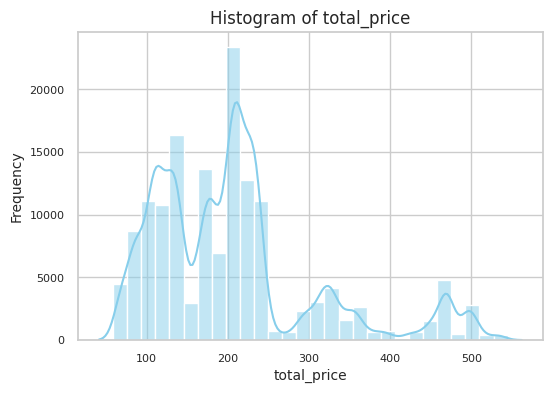

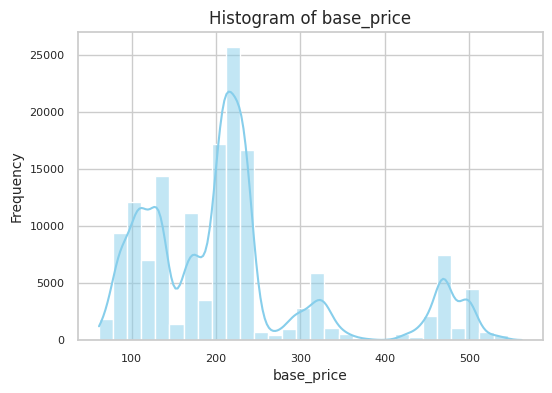

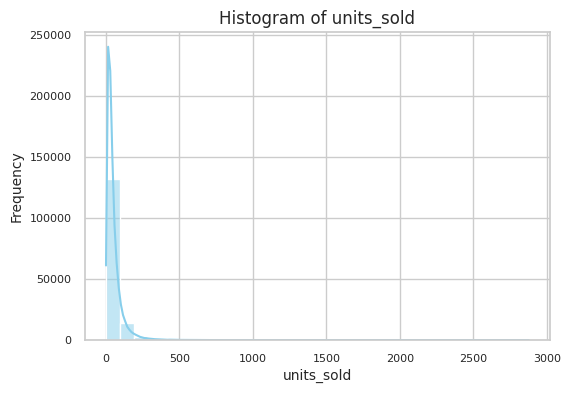



===== Boxplots for Numerical Features =====


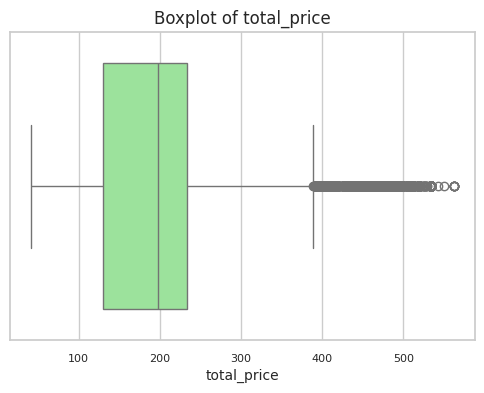

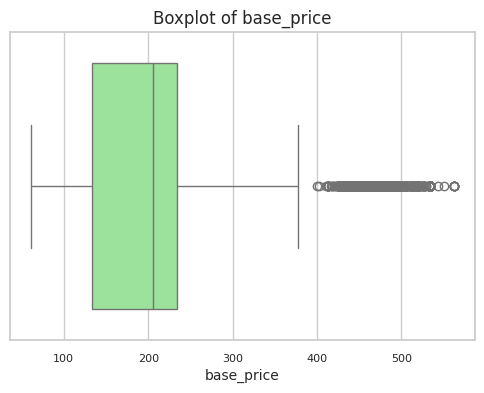

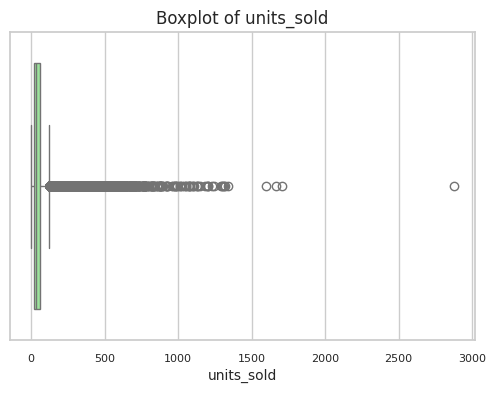



===== Correlation Heatmap (Numerical Features) =====


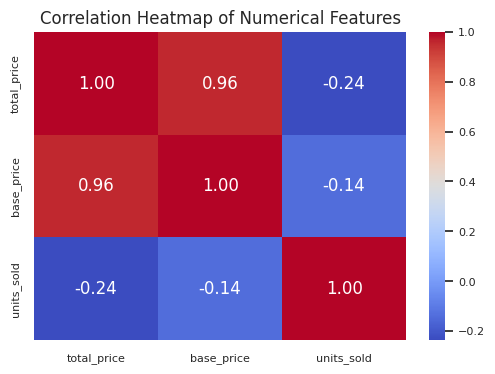



===== Unique Values for Categorical and Time-based Variables =====
'record_ID': 150150 unique values
'store_id': 76 unique values
'sku_id': 28 unique values
'is_featured_sku': 2 unique values
'is_display_sku': 2 unique values
'day': 31 unique values
'month': 12 unique values
'year': 3 unique values
'week_of_year': 52 unique values
'day_of_week': 2 unique values
'is_start_of_year': 2 unique values
'is_end_of_year': 2 unique values
'week_of_month': 6 unique values


===== Boxplot of 'units_sold' by Time-based Features =====


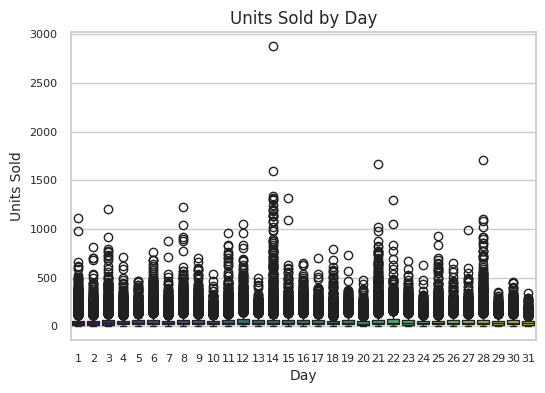

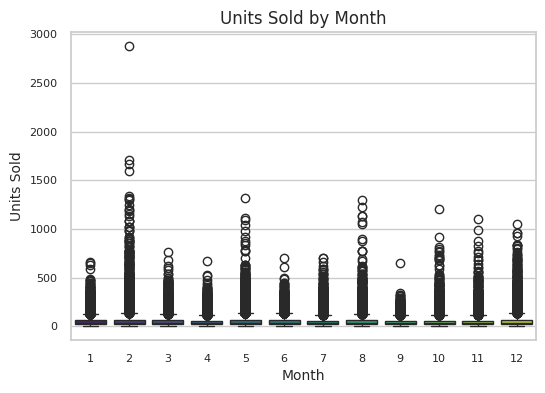

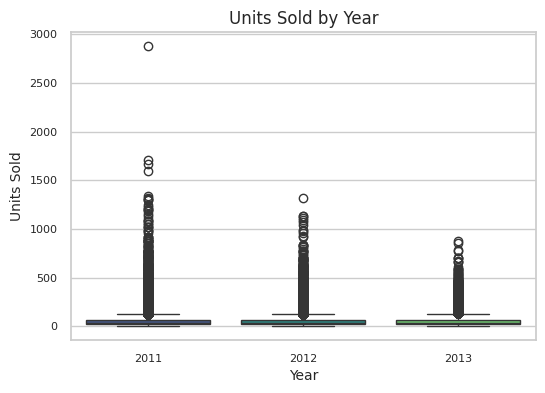



===== Bar Plot of Total Units Sold per Month =====


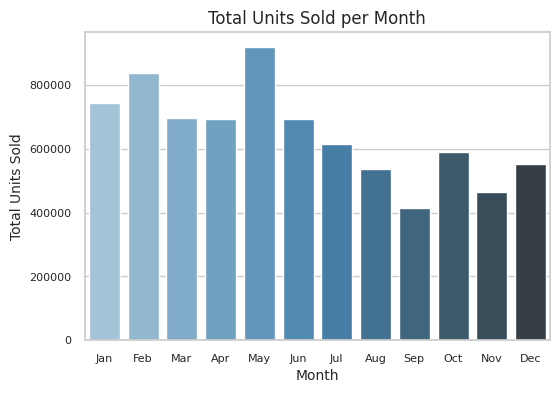



===== Bar Plot of Total Units Sold per Year =====


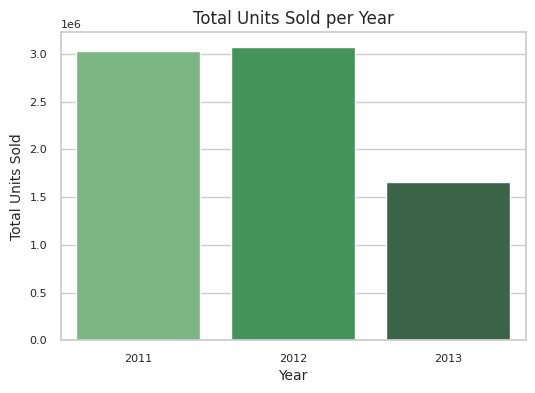



===== Bar Plot of Total Units Sold by Item (sku_id) for Each Year =====


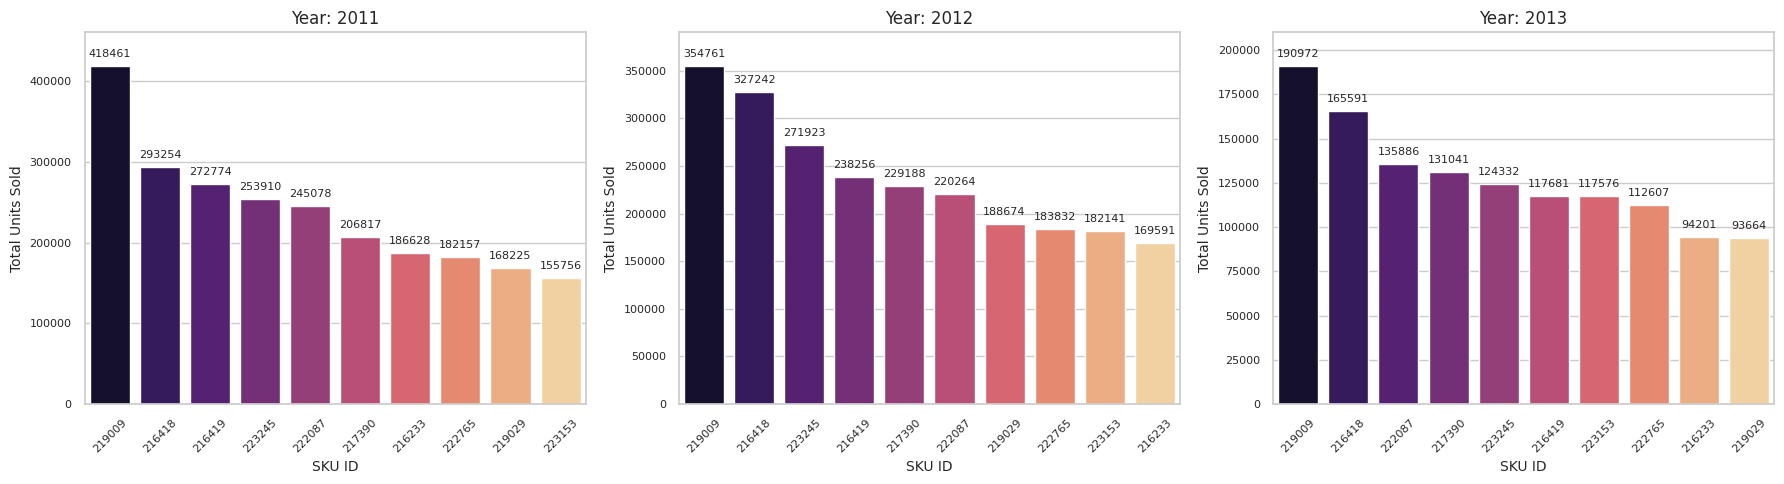



===== Data Exploration Completed =====


In [10]:
# Perform comprehensive EDA
explore_data(df)

# Engineer Features

In [11]:
def feature_engineering(df):
    """
    Perform feature engineering tailored for longitudinal panel data.

    Parameters:
    - df (pd.DataFrame): The DataFrame to engineer features on.

    Returns:
    - df (pd.DataFrame): DataFrame with new features.
    """
    # Ensure the data is sorted chronologically for each store and SKU
    df = df.sort_values(['store_id', 'sku_id', 'date'])

    # Create Lag Features: Previous 1, 2, and 3 weeks' units_sold
    df['units_sold_lag_1'] = df.groupby(['store_id', 'sku_id'])['units_sold'].shift(1)
    df['units_sold_lag_2'] = df.groupby(['store_id', 'sku_id'])['units_sold'].shift(2)
    df['units_sold_lag_3'] = df.groupby(['store_id', 'sku_id'])['units_sold'].shift(3)

    # Create Rolling Features: 4-week rolling mean and std
    df['units_sold_roll_mean_4'] = df.groupby(['store_id', 'sku_id'])['units_sold'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())
    df['units_sold_roll_std_4'] = df.groupby(['store_id', 'sku_id'])['units_sold'].transform(lambda x: x.rolling(window=4, min_periods=1).std())

    # Exponential Moving Average (span=4)
    df['units_sold_ema_4'] = df.groupby(['store_id', 'sku_id'])['units_sold'].transform(lambda x: x.ewm(span=4, adjust=False).mean())

    # Create Differenced Features for Stationarity
    df['units_sold_diff_1'] = df.groupby(['store_id', 'sku_id'])['units_sold'].diff(1)
    df['units_sold_diff_2'] = df.groupby(['store_id', 'sku_id'])['units_sold'].diff(2)

    # Drop rows with NaN values resulting from lagged and differenced features
    df = df.dropna(subset=['units_sold_lag_1', 'units_sold_lag_2', 'units_sold_lag_3',
                           'units_sold_roll_mean_4', 'units_sold_roll_std_4', 'units_sold_ema_4',
                           'units_sold_diff_1', 'units_sold_diff_2'])

    # Reset index after dropping rows
    df = df.reset_index(drop=True)

    # Create Interaction Features
    df['price_per_unit'] = df['total_price'] / df['units_sold']

    # Cyclical Encoding for Month and Week of Year
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    df['week_sin'] = np.sin(2 * np.pi * df['week_of_year']/52)
    df['week_cos'] = np.cos(2 * np.pi * df['week_of_year']/52)

    print("===== Feature Engineering Completed =====")
    print(f"Data shape after feature engineering: {df.shape}")

    display(df.head())

    return df

In [12]:
# Apply feature engineering
df = feature_engineering(df)

===== Feature Engineering Completed =====
Data shape after feature engineering: (146685, 30)


,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,date,day,month,year,week_of_year,day_of_week,is_start_of_year,is_end_of_year,week_of_month,units_sold_lag_1,units_sold_lag_2,units_sold_lag_3,units_sold_roll_mean_4,units_sold_roll_std_4,units_sold_ema_4,units_sold_diff_1,units_sold_diff_2,price_per_unit,month_sin,month_cos,week_sin,week_cos
0,5011,8023,216233,133.9500,133.9500,0,0,115,2011-02-07,7,2,2011,6,0,0,0,2,135.0,87.0,114.0,112.75,19.704060,115.552000,-20.0,28.0,1.164783,0.866025,5.000000e-01,0.663123,0.748511
1,6651,8023,216233,133.2375,133.2375,0,0,93,2011-02-14,14,2,2011,7,0,0,0,3,115.0,135.0,87.0,107.50,21.931712,106.531200,-22.0,-42.0,1.432661,0.866025,5.000000e-01,0.748511,0.663123
2,8289,8023,216233,115.4250,133.2375,0,0,150,2011-02-21,21,2,2011,8,0,0,0,4,93.0,115.0,135.0,123.25,24.743686,123.918720,57.0,35.0,0.769500,0.866025,5.000000e-01,0.822984,0.568065
3,9923,8023,216233,115.4250,133.2375,0,0,134,2011-02-28,28,2,2011,9,0,0,0,5,150.0,93.0,115.0,123.00,24.589971,127.951232,-16.0,41.0,0.861381,0.866025,5.000000e-01,0.885456,0.464723
4,11537,8023,216233,117.5625,133.2375,0,0,130,2011-03-07,7,3,2011,10,0,0,0,2,134.0,150.0,93.0,126.75,24.102213,128.770739,-4.0,-20.0,0.904327,1.000000,6.123234e-17,0.935016,0.354605


In [13]:
def interactive_correlation_heatmap(df):
    """
    Create an interactive correlation heatmap using Plotly.

    Parameters:
    - df (pd.DataFrame): The DataFrame to visualize.

    Returns:
    - None
    """
    # Select numerical features including the target variable and engineered features
    numerical_cols = ['total_price', 'base_price', 'units_sold', 'units_sold_lag_1',
                      'units_sold_lag_2', 'units_sold_lag_3', 'units_sold_roll_mean_4',
                      'units_sold_roll_std_4', 'units_sold_ema_4', 'price_per_unit',
                      'month_sin', 'month_cos', 'week_sin', 'week_cos',
                      'units_sold_diff_1', 'units_sold_diff_2']

    corr = df[numerical_cols].corr()
    fig = px.imshow(corr,
                    text_auto=True,
                    aspect="auto",
                    color_continuous_scale='RdBu_r',
                    title='Interactive Correlation Heatmap')
    fig.show()

In [14]:
# # Interactive Correlation Heatmap
# interactive_correlation_heatmap(df)

In [15]:
def interactive_scatter_plot(df, x_col, y_col, color_col=None):
    """
    Create an interactive scatter plot using Plotly.

    Parameters:
    - df (pd.DataFrame): The DataFrame to visualize.
    - x_col (str): Column name for the x-axis.
    - y_col (str): Column name for the y-axis.
    - color_col (str): Column name for color encoding.

    Returns:
    - None
    """
    fig = px.scatter(df, x=x_col, y=y_col, color=color_col,
                     title=f'Interactive Scatter Plot: {y_col} vs. {x_col}',
                     hover_data=df.columns)
    fig.show()

In [16]:
# # Interactive Scatter Plot for Price per Unit vs. Units Sold
# if 'price_per_unit' in df.columns:
#     interactive_scatter_plot(df, 'price_per_unit', 'units_sold')
# else:
#     print("Column 'price_per_unit' not found.")

In [17]:
def interactive_time_series_plot(df, group_cols, time_col, target_col):
    """
    Create an interactive time series plot using Plotly for multiple entities.

    Parameters:
    - df (pd.DataFrame): The DataFrame to visualize.
    - group_cols (list): Columns to group by (e.g., ['store_id', 'sku_id']).
    - time_col (str): Column name for the time axis.
    - target_col (str): Column name for the target variable.

    Returns:
    - None
    """
    # Aggregate data if necessary
    fig = px.line(df, x=time_col, y=target_col, color=group_cols[0],
                  line_group=group_cols[1],
                  title=f'Interactive Time Series Plot: {target_col} Over Time by {group_cols}',
                  hover_data=df.columns)
    fig.show()

In [18]:
# # Interactive Time Series Plot for Units Sold over Time by Store and SKU
# if 'date' in df.columns and 'store_id' in df.columns and 'sku_id' in df.columns:
#     # Sort the DataFrame by date
#     sorted_df = df.sort_values('date')
#     interactive_time_series_plot(sorted_df, ['store_id', 'sku_id'], 'date', 'units_sold')
# else:
#     print("Necessary columns for time series plot not found.")

# Preprocess the Data

In [19]:
def preprocess_data(df):
    """
    Preprocess the DataFrame by handling categorical variables using Target Encoding and scaling numerical features.

    Parameters:
    - df (pd.DataFrame): The DataFrame to preprocess.

    Returns:
    - X (pd.DataFrame): Features after preprocessing.
    - y (pd.Series): Target variable.
    - preprocessor (ColumnTransformer): The preprocessing pipeline.
    - feature_names (list): List of feature names after preprocessing.
    """
    # Define target variable
    y = df['units_sold']

    # Define feature set by dropping target and non-predictive columns
    # 'record_ID' and 'date' are identifiers and date features
    X = df.drop(['units_sold', 'record_ID', 'date'], axis=1)

    # Identify numerical and categorical columns
    numerical_cols = ['total_price', 'base_price', 'units_sold_lag_1', 'units_sold_lag_2',
                      'units_sold_lag_3', 'units_sold_roll_mean_4', 'units_sold_roll_std_4',
                      'units_sold_ema_4', 'price_per_unit', 'month_sin', 'month_cos',
                      'week_sin', 'week_cos',
                      'units_sold_diff_1', 'units_sold_diff_2']
    categorical_cols = ['store_id', 'sku_id',
                        'is_featured_sku', 'is_display_sku',
                        'is_start_of_year', 'is_end_of_year']

    # Preprocessing for numerical data
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # Preprocessing for categorical data using Target Encoding
    categorical_transformer = Pipeline(steps=[
        ('target_encoder', TargetEncoder())
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # Note: Preprocessing will be handled within the modeling pipeline to prevent data leakage

    print("===== Data Preprocessing Setup Completed =====")
    print(f"Numerical Columns: {numerical_cols}")
    print(f"Categorical Columns: {categorical_cols}")

    # Compile feature names after preprocessing
    # Since TargetEncoder outputs numerical columns, all features remain numerical after encoding
    feature_names = numerical_cols + categorical_cols

    return X, y, preprocessor, feature_names

In [20]:
# Preprocess the data
X, y, preprocessor, feature_names = preprocess_data(df)

===== Data Preprocessing Setup Completed =====
Numerical Columns: ['total_price', 'base_price', 'units_sold_lag_1', 'units_sold_lag_2', 'units_sold_lag_3', 'units_sold_roll_mean_4', 'units_sold_roll_std_4', 'units_sold_ema_4', 'price_per_unit', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'units_sold_diff_1', 'units_sold_diff_2']
Categorical Columns: ['store_id', 'sku_id', 'is_featured_sku', 'is_display_sku', 'is_start_of_year', 'is_end_of_year']


In [21]:
# Inspect shapes
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Inspect first few rows of preprocessed features
print("\nFirst 5 rows of preprocessed features:")
display(pd.DataFrame(X[:5], columns=feature_names))

# Inspect first few rows of the target
print("\nFirst 5 rows of the target:")
display(y[:5])

Shape of X: (146685, 27)
Shape of y: (146685,)

First 5 rows of preprocessed features:


,total_price,base_price,units_sold_lag_1,units_sold_lag_2,units_sold_lag_3,units_sold_roll_mean_4,units_sold_roll_std_4,units_sold_ema_4,price_per_unit,month_sin,month_cos,week_sin,week_cos,units_sold_diff_1,units_sold_diff_2,store_id,sku_id,is_featured_sku,is_display_sku,is_start_of_year,is_end_of_year
0,133.9500,133.9500,135.0,87.0,114.0,112.75,19.704060,115.552000,1.164783,0.866025,5.000000e-01,0.663123,0.748511,-20.0,28.0,8023,216233,0,0,0,0
1,133.2375,133.2375,115.0,135.0,87.0,107.50,21.931712,106.531200,1.432661,0.866025,5.000000e-01,0.748511,0.663123,-22.0,-42.0,8023,216233,0,0,0,0
2,115.4250,133.2375,93.0,115.0,135.0,123.25,24.743686,123.918720,0.769500,0.866025,5.000000e-01,0.822984,0.568065,57.0,35.0,8023,216233,0,0,0,0
3,115.4250,133.2375,150.0,93.0,115.0,123.00,24.589971,127.951232,0.861381,0.866025,5.000000e-01,0.885456,0.464723,-16.0,41.0,8023,216233,0,0,0,0
4,117.5625,133.2375,134.0,150.0,93.0,126.75,24.102213,128.770739,0.904327,1.000000,6.123234e-17,0.935016,0.354605,-4.0,-20.0,8023,216233,0,0,0,0



First 5 rows of the target:


,units_sold
0,115
1,93
2,150
3,134
4,130


In [22]:
def split_data(X, y, test_size=0.2, val_size=0.25, random_state=42):
    """
    Split the data into training, validation, and testing sets based on temporal ordering.

    Parameters:
    - X (pd.DataFrame): Features after preprocessing.
    - y (pd.Series): Target variable.
    - test_size (float): Proportion of data to be used as test set.
    - val_size (float): Proportion of training data to be used as validation set.
    - random_state (int): Random state for reproducibility.

    Returns:
    - X_train, X_val, X_test, y_train, y_val, y_test: Split datasets.
    """
    # First split: Train/Val and Test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False)

    # Second split: Train and Validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size, shuffle=False)

    print("===== Data Split Completed =====")
    print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
    print(f"Testing set: X_test: {X_test.shape}, y_test: {y_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test

In [23]:
# Split the data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, test_size=0.2, val_size=0.25, random_state=42)

===== Data Split Completed =====
Training set: X_train: (88011, 27), y_train: (88011,)
Validation set: X_val: (29337, 27), y_val: (29337,)
Testing set: X_test: (29337, 27), y_test: (29337,)


In [24]:
# Verify splits
print("===== Training Set Statistics =====")
display(pd.Series(y_train).describe())

print("\n===== Validation Set Statistics =====")
display(pd.Series(y_val).describe())

print("\n===== Testing Set Statistics =====")
display(pd.Series(y_test).describe())

===== Training Set Statistics =====


,units_sold
count,88011.000000
mean,48.976867
std,57.075274
min,1.000000
25%,19.000000
50%,33.000000
75%,58.000000
max,1341.000000



===== Validation Set Statistics =====


,units_sold
count,29337.000000
mean,53.789310
std,59.713349
min,1.000000
25%,21.000000
50%,37.000000
75%,65.000000
max,1295.000000



===== Testing Set Statistics =====


,units_sold
count,29337.000000
mean,58.019361
std,70.276960
min,1.000000
25%,22.000000
50%,39.000000
75%,71.000000
max,2876.000000


# Train the Model

In [25]:
def train_models_with_pipeline(X_train, y_train, preprocessor):
    """
    Train multiple regression models with preprocessing pipeline.

    Parameters:
    - X_train (pd.DataFrame): Training features.
    - y_train (pd.Series): Training target variable.
    - preprocessor (ColumnTransformer): Preprocessing pipeline.

    Returns:
    - models (dict): Dictionary of trained models with pipelines.
    """
    models = {}

    # Histogram-Based Gradient Boosting Regressor Pipeline
    hgb_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', HistGradientBoostingRegressor(random_state=42))
    ])
    hgb_pipeline.fit(X_train, y_train)
    models['HistGradientBoosting'] = hgb_pipeline
    print("Trained Histogram-Based Gradient Boosting Regressor with pipeline.")

    # Random Forest Regressor Pipeline
    rf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    rf_pipeline.fit(X_train, y_train)
    models['RandomForest'] = rf_pipeline
    print("Trained Random Forest Regressor with pipeline.")

    # XGBoost Regressor Pipeline
    xgb_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', xgboost.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, objective='reg:squarederror'))
    ])
    xgb_pipeline.fit(X_train, y_train)
    models['XGBoost'] = xgb_pipeline
    print("Trained XGBoost Regressor with pipeline.")

    # LightGBM Regressor Pipeline
    lgbm_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', lightgbm.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
    ])
    lgbm_pipeline.fit(X_train, y_train)
    models['LightGBM'] = lgbm_pipeline
    print("Trained LightGBM Regressor with pipeline.")

    # CatBoost Regressor Pipeline
    catboost_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', catboost.CatBoostRegressor(
            iterations=100, learning_rate=0.1, depth=6, verbose=0, random_state=42))
    ])
    catboost_pipeline.fit(X_train, y_train)
    models['CatBoost'] = catboost_pipeline
    print("Trained CatBoost Regressor with pipeline.")

    # Stacking Regressor
    estimators = [
        ('hgb', models['HistGradientBoosting']),
        ('rf', models['RandomForest']),
        ('xgb', models['XGBoost']),
        ('lgbm', models['LightGBM']),
        ('catboost', models['CatBoost'])
    ]
    stacking_reg = StackingRegressor(
        estimators=estimators,
        final_estimator=HistGradientBoostingRegressor(random_state=42),
        cv=5,
        passthrough=False,
        n_jobs=-1
    )
    stacking_reg.fit(X_train, y_train)
    models['StackingRegressor'] = stacking_reg
    print("Trained Stacking Regressor with pipeline.")

    return models

In [26]:
# Train models with pipelines
models = train_models_with_pipeline(X_train, y_train, preprocessor)

Trained Histogram-Based Gradient Boosting Regressor with pipeline.
Trained Random Forest Regressor with pipeline.
Trained XGBoost Regressor with pipeline.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2968
[LightGBM] [Info] Number of data points in the train set: 88011, number of used features: 21
[LightGBM] [Info] Start training from score 48.976867
Trained LightGBM Regressor with pipeline.
Trained CatBoost Regressor with pipeline.
Trained Stacking Regressor with pipeline.


In [27]:
# List trained models
print("===== Trained Models =====\n")
for model_name in models.keys():
    print(f"- {model_name}")

===== Trained Models =====

- HistGradientBoosting
- RandomForest
- XGBoost
- LightGBM
- CatBoost
- StackingRegressor


In [28]:
def save_model(model, preprocessor, model_path='model.joblib', preprocessor_path='preprocessor.joblib'):
    """
    Save the trained model and preprocessor to disk.

    Parameters:
    - model: Trained machine learning model.
    - preprocessor: Fitted preprocessor.
    - model_path (str): File path to save the model.
    - preprocessor_path (str): File path to save the preprocessor.

    Returns:
    - None
    """
    joblib.dump(model, model_path)
    joblib.dump(preprocessor, preprocessor_path)
    print(f"Model saved to {model_path}")
    print(f"Preprocessor saved to {preprocessor_path}\n")

In [29]:
# # Save models and preprocessor
# save_model(models['HistGradientBoosting'], preprocessor,
#            model_path='histgradientboosting_model.joblib',
#            preprocessor_path='preprocessor.joblib')

# save_model(models['RandomForest'], preprocessor,
#            model_path='random_forest_model.joblib',
#            preprocessor_path='preprocessor.joblib')

# save_model(models['XGBoost'], preprocessor,
#            model_path='xgboost_model.joblib',
#            preprocessor_path='preprocessor.joblib')

# save_model(models['LightGBM'], preprocessor,
#            model_path='lightgbm_model.joblib',
#            preprocessor_path='preprocessor.joblib')

# save_model(models['CatBoost'], preprocessor,
#            model_path='catboost_model.joblib',
#            preprocessor_path='preprocessor.joblib')

# save_model(models['StackingRegressor'], preprocessor,
#            model_path='stacking_regressor_model.joblib',
#            preprocessor_path='preprocessor.joblib')

# print("Models and preprocessor saved.")

# Evaluate the Model

In [30]:
def evaluate_models_cross_validated(models, X, y, cv_splits=5):
    """
    Evaluate trained models using cross-validation on the provided dataset.

    Parameters:
    - models (dict): Dictionary of trained models.
    - X (pd.DataFrame): Features for evaluation.
    - y (pd.Series): Target variable for evaluation.
    - cv_splits (int): Number of cross-validation splits.

    Returns:
    - evaluation_results (dict): Dictionary containing cross-validated evaluation metrics for each model.
    """
    evaluation_results = {}

    # Define custom scoring functions
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    def mae(y_true, y_pred):
        return mean_absolute_error(y_true, y_pred)

    def mape(y_true, y_pred):
        return mean_absolute_percentage_error(y_true, y_pred)

    # Create a scoring dictionary
    scoring = {
        'RMSE': make_scorer(rmse, greater_is_better=False),
        'MAE': make_scorer(mae, greater_is_better=False),
        'MAPE': make_scorer(mape, greater_is_better=False),
        'R2': make_scorer(r2_score, greater_is_better=True),
    }

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=cv_splits)

    for name, model in models.items():
        print(f"===== Evaluating {name} with Cross-Validation =====")

        # Perform cross-validation
        cv_rmse = cross_val_score(model, X, y, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
        rmse_scores = -cv_rmse  # Since scores are negative

        cv_mae = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
        mae_scores = -cv_mae

        cv_mape = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
        mape_scores = -cv_mape

        cv_r2 = cross_val_score(model, X, y, cv=tscv, scoring='r2', n_jobs=-1)
        r2_scores = cv_r2

        # Store the mean and std of each metric
        metrics = {
            'Cross-Validated RMSE': rmse_scores.mean(),
            'Cross-Validated RMSE Std': rmse_scores.std(),
            'Cross-Validated MAE': mae_scores.mean(),
            'Cross-Validated MAE Std': mae_scores.std(),
            'Cross-Validated MAPE': mape_scores.mean(),
            'Cross-Validated MAPE Std': mape_scores.std(),
            'Cross-Validated R²': r2_scores.mean(),
            'Cross-Validated R² Std': r2_scores.std()
        }

        for metric, value in metrics.items():
            print(f"{metric}: {value:.2f}")

        # Store Metrics
        evaluation_results[name] = metrics

        # Visualization: Boxplots for each metric across folds
        print("\n")
        metrics_data = pd.DataFrame({
            'RMSE': rmse_scores,
            'MAE': mae_scores,
            'MAPE': mape_scores,
            'R²': r2_scores
        })

        plt.figure(figsize=(6, 4))
        sns.boxplot(data=metrics_data)
        plt.title(f'{name} - Cross-Validated Metrics Distribution')
        plt.ylabel('Metric Value')
        plt.show()
        print("\n")

    return evaluation_results

===== Evaluating HistGradientBoosting with Cross-Validation =====
Cross-Validated RMSE: 6.12
Cross-Validated RMSE Std: 2.26
Cross-Validated MAE: 2.16
Cross-Validated MAE Std: 0.59
Cross-Validated MAPE: 0.06
Cross-Validated MAPE Std: 0.01
Cross-Validated R²: 0.99
Cross-Validated R² Std: 0.01




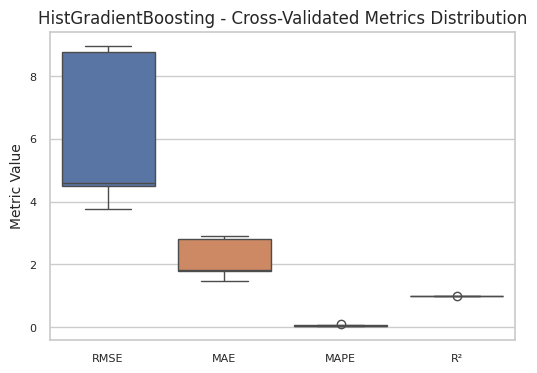



===== Evaluating RandomForest with Cross-Validation =====
Cross-Validated RMSE: 4.17
Cross-Validated RMSE Std: 1.97
Cross-Validated MAE: 1.71
Cross-Validated MAE Std: 0.67
Cross-Validated MAPE: 0.04
Cross-Validated MAPE Std: 0.01
Cross-Validated R²: 0.99
Cross-Validated R² Std: 0.00




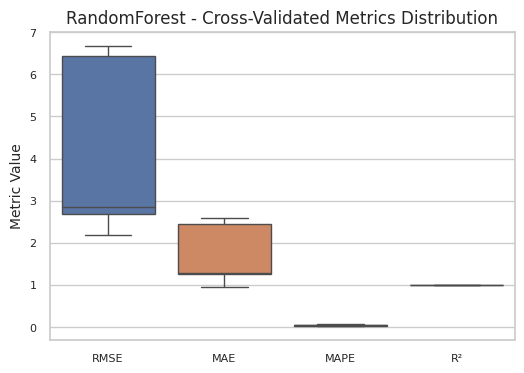



===== Evaluating XGBoost with Cross-Validation =====
Cross-Validated RMSE: 6.00
Cross-Validated RMSE Std: 1.96
Cross-Validated MAE: 2.03
Cross-Validated MAE Std: 0.62
Cross-Validated MAPE: 0.05
Cross-Validated MAPE Std: 0.01
Cross-Validated R²: 0.99
Cross-Validated R² Std: 0.01




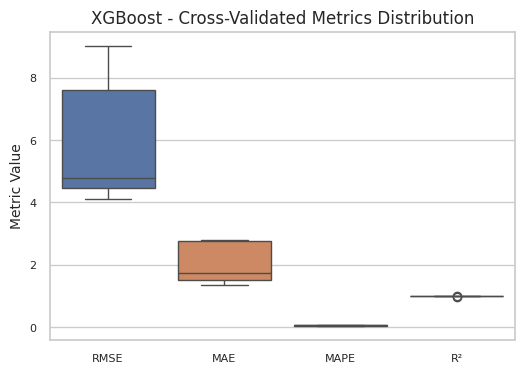



===== Evaluating LightGBM with Cross-Validation =====
Cross-Validated RMSE: 6.50
Cross-Validated RMSE Std: 3.15
Cross-Validated MAE: 2.11
Cross-Validated MAE Std: 0.69
Cross-Validated MAPE: 0.05
Cross-Validated MAPE Std: 0.01
Cross-Validated R²: 0.99
Cross-Validated R² Std: 0.01




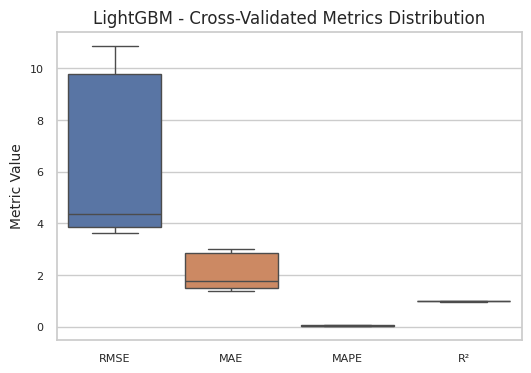



===== Evaluating CatBoost with Cross-Validation =====
Cross-Validated RMSE: 5.65
Cross-Validated RMSE Std: 1.32
Cross-Validated MAE: 2.96
Cross-Validated MAE Std: 0.64
Cross-Validated MAPE: 0.10
Cross-Validated MAPE Std: 0.02
Cross-Validated R²: 0.99
Cross-Validated R² Std: 0.00




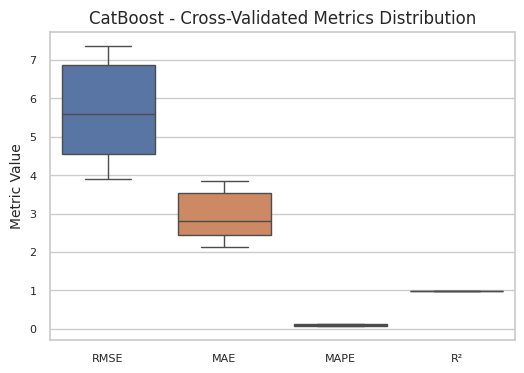



===== Evaluating StackingRegressor with Cross-Validation =====
Cross-Validated RMSE: 9.48
Cross-Validated RMSE Std: 1.80
Cross-Validated MAE: 2.03
Cross-Validated MAE Std: 0.69
Cross-Validated MAPE: 0.05
Cross-Validated MAPE Std: 0.01
Cross-Validated R²: 0.97
Cross-Validated R² Std: 0.01




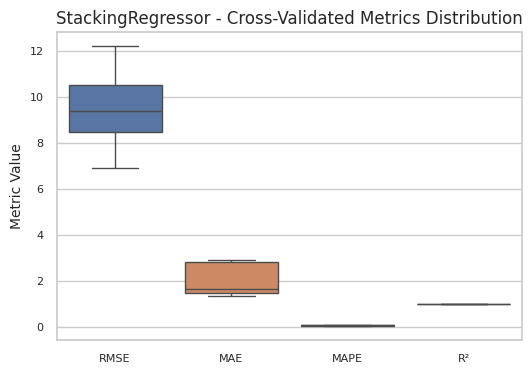

In [31]:
# Evaluate models using cross-validation on the validation set
evaluation_results = evaluate_models_cross_validated(models, X_val, y_val, cv_splits=5)

In [32]:
def select_best_model(evaluation_results, metric='Cross-Validated RMSE', minimize=True):
    """
    Select the best performing model based on a specified evaluation metric.

    Parameters:
    - evaluation_results (dict): Dictionary containing evaluation metrics for each model.
    - metric (str): The metric to base the selection on.
    - minimize (bool): Whether to minimize or maximize the metric.

    Returns:
    - best_model_name (str): The name of the best performing model.
    """
    best_score = None
    best_model_name = None

    for model_name, metrics in evaluation_results.items():
        score = metrics.get(metric, None)
        if score is None:
            continue
        if best_score is None:
            best_score = score
            best_model_name = model_name
        else:
            if minimize:
                if score < best_score:
                    best_score = score
                    best_model_name = model_name
            else:
                if score > best_score:
                    best_score = score
                    best_model_name = model_name

    print(f"===== Best Model Selected =====\nModel: {best_model_name} with {metric}: {best_score:.2f}")
    return best_model_name

In [33]:
# Identify the best model based on Cross-Validated RMSE
best_model_name = select_best_model(evaluation_results, metric='Cross-Validated RMSE', minimize=True)
best_model_pipeline = models[best_model_name]

===== Best Model Selected =====
Model: RandomForest with Cross-Validated RMSE: 4.17


# Tune the Models

## CMA-ES

In [34]:
def evaluate_solution_rf(params, model_pipeline, X_train, y_train, cv_splits, seed):
    """
    Evaluates a single set of hyperparameters using cross-validation.

    Parameters:
    - params (list or np.ndarray): [n_estimators, max_depth, min_samples_split, min_samples_leaf]
    - model_pipeline (Pipeline): The pipeline containing preprocessing and Random Forest regressor.
    - X_train (pd.DataFrame): Training features.
    - y_train (pd.Series): Training target variable.
    - cv_splits (int): Number of cross-validation splits.
    - seed (int): Random state for reproducibility.

    Returns:
    - avg_rmse (float): Average RMSE across cross-validation folds.
    """
    try:
        # Clone the pipeline to prevent shared state issues
        pipeline_clone = clone(model_pipeline)

        # Unpack and clip hyperparameters
        n_estimators, max_depth, min_samples_split, min_samples_leaf = params
        n_estimators = int(np.clip(n_estimators, 100, 1000))
        max_depth = int(np.clip(max_depth, 10, 50))
        min_samples_split = int(np.clip(min_samples_split, 2, 20))
        min_samples_leaf = int(np.clip(min_samples_leaf, 1, 20))

        # Set hyperparameters
        pipeline_clone.named_steps['regressor'].set_params(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=seed
        )

        # Initialize cross-validator
        tscv = TimeSeriesSplit(n_splits=cv_splits)

        rmse_scores = []

        # Perform cross-validation
        for train_index, val_index in tscv.split(X_train):
            X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

            # Fit the model
            pipeline_clone.fit(X_train_cv, y_train_cv)

            # Predict on validation set
            y_pred_cv = pipeline_clone.predict(X_val_cv)

            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
            rmse_scores.append(rmse)

        # Return the average RMSE across folds
        return np.mean(rmse_scores)
    except Exception as e:
        # If any error occurs, return a large RMSE to penalize the solution
        print(f"Exception in evaluate_solution_rf with params {params}: {e}")
        return float('inf')

In [35]:
def cma_es_hyperparameter_tuning_rf(model_pipeline, X_train, y_train, cv_splits=5, seed=42,
                                    max_iterations=50, population_size=10, workers=None):
    """
    Perform hyperparameter tuning using CMA-ES with TimeSeriesSplit cross-validation for Random Forest Regressor.
    Incorporates parallel processing to evaluate multiple solutions simultaneously and enhanced progress reporting.

    Parameters:
    - model_pipeline (Pipeline): The pipeline containing preprocessing and Random Forest regressor.
    - X_train (pd.DataFrame): Training features.
    - y_train (pd.Series): Training target variable.
    - cv_splits (int): Number of cross-validation splits.
    - seed (int): Random state for reproducibility.
    - max_iterations (int): Maximum number of CMA-ES iterations.
    - population_size (int): Number of solutions per CMA-ES iteration.
    - workers (int): Number of parallel workers for evaluation. If None, uses all available cores.

    Returns:
    - best_params (dict): Best hyperparameters found.
    - best_score (float): Best cross-validated RMSE score.
    """
    # Determine number of workers
    if workers is None:
        workers = multiprocessing.cpu_count()

    # Initial guess for hyperparameters [n_estimators, max_depth, min_samples_split, min_samples_leaf]
    initial_guess = [200, 20, 5, 5]

    # Standard deviation for the initial step size (sigma0)
    sigma0 = 50

    # Define bounds for hyperparameters
    lower_bounds = [100, 10, 2, 1]
    upper_bounds = [1000, 50, 20, 20]

    # Initialize CMA-ES optimization
    es = cma.CMAEvolutionStrategy(initial_guess, sigma0, {
        'bounds': [lower_bounds, upper_bounds],
        'popsize': population_size,
        'verb_disp': 0  # Disable default verbosity to integrate with tqdm
    })

    # Initialize progress bar
    pbar = tqdm(total=max_iterations, desc='CMA-ES Tuning Progress', unit='iter')

    # Optimization loop
    for iteration in range(1, max_iterations + 1):
        # Ask for new solutions
        solutions = es.ask()

        # Prepare arguments for evaluation
        args = [(sol, model_pipeline, X_train, y_train, cv_splits, seed) for sol in solutions]

        # Evaluate solutions in parallel using joblib
        scores = []
        try:
            # Use joblib's Parallel and delayed
            results = Parallel(n_jobs=workers, backend='loky')(
                delayed(evaluate_solution_rf)(sol, model_pipeline, X_train, y_train, cv_splits, seed)
                for sol in solutions
            )
            scores = results
        except Exception as e:
            print(f"Error during parallel evaluation: {e}")
            # Assign a large RMSE to all solutions in case of failure
            scores = [float('inf')] * len(solutions)

        # Tell CMA-ES the scores
        es.tell(solutions, scores)

        # Update progress bar
        current_best_rmse = es.result.fbest
        pbar.update(1)
        pbar.set_postfix({'Best RMSE': f"{current_best_rmse:.2f}"})

        # Check if CMA-ES has stopped
        if es.stop():
            print("CMA-ES stopping criteria met.")
            break

    # Close progress bar
    pbar.close()

    # Retrieve the best parameters and corresponding RMSE
    best_params_values = es.result.xbest
    best_rmse = es.result.fbest

    # Check if best_params_values is not None
    if best_params_values is None:
        print("CMA-ES did not find any valid solutions.")
        return None, None

    # Convert hyperparameters to appropriate types and apply constraints
    n_estimators = int(np.clip(best_params_values[0], lower_bounds[0], upper_bounds[0]))
    max_depth = int(np.clip(best_params_values[1], lower_bounds[1], upper_bounds[1]))
    min_samples_split = int(np.clip(best_params_values[2], lower_bounds[2], upper_bounds[2]))
    min_samples_leaf = int(np.clip(best_params_values[3], lower_bounds[3], upper_bounds[3]))

    best_params = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf
    }

    print("\n===== CMA-ES Hyperparameter Tuning Completed =====")
    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validated RMSE: {best_rmse:.2f}")

    return best_params, best_rmse

In [36]:
# Perform CMA-ES hyperparameter tuning with parallel processing
best_params_cma, best_score_cma = cma_es_hyperparameter_tuning_rf(
    model_pipeline=best_model_pipeline,
    X_train=X_train,
    y_train=y_train,
    cv_splits=5,
    seed=42,
    max_iterations=5,
    population_size=10
)

CMA-ES Tuning Progress:   0%|          | 0/5 [00:00<?, ?iter/s]


===== CMA-ES Hyperparameter Tuning Completed =====
Best Parameters: {'n_estimators': 204, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1}
Best Cross-Validated RMSE: 3.70


## Bayesian

In [37]:
def optuna_bayesian_optimization_rf(model_pipeline, X_train, y_train, cv_splits=5, seed=42, n_trials=50):
    """
    Perform hyperparameter tuning using Optuna with TimeSeriesSplit cross-validation for Random Forest Regressor.
    Incorporates progress reporting using tqdm via a callback function.

    Parameters:
    - model_pipeline (Pipeline): The pipeline containing preprocessing and Random Forest regressor.
    - X_train (pd.DataFrame): Training features.
    - y_train (pd.Series): Training target variable.
    - cv_splits (int): Number of cross-validation splits.
    - seed (int): Random state for reproducibility.
    - n_trials (int): Number of optimization trials.

    Returns:
    - best_params (dict): Best hyperparameters found.
    - best_score (float): Best cross-validated RMSE score.
    """
    # Initialize the progress bar
    progress_bar = tqdm(total=n_trials, desc="Optuna Tuning Progress", unit="trial")

    def objective(trial):
        # Define the search space for Random Forest Regressor
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 50)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

        # Set the hyperparameters
        model_pipeline.named_steps['regressor'].set_params(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=seed
        )

        # Define TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=cv_splits)

        rmse_scores = []

        for train_index, val_index in tscv.split(X_train):
            X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

            # Fit the model
            model_pipeline.fit(X_train_cv, y_train_cv)

            # Predict on validation set
            y_pred_cv = model_pipeline.predict(X_val_cv)

            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
            rmse_scores.append(rmse)

        # Calculate the average RMSE
        avg_rmse = np.mean(rmse_scores)

        # Report intermediate objective value
        trial.report(avg_rmse, step=1)

        # Prune trials that are not promising
        if trial.should_prune():
            raise TrialPruned()

        return avg_rmse

    def callback(study, trial):
        # Update the progress bar after each trial
        progress_bar.update(1)
        try:
            best_rmse = study.best_value
            progress_bar.set_postfix({'Best RMSE': f"{best_rmse:.2f}"})
        except ValueError:
            # No trials have been completed yet
            progress_bar.set_postfix({'Best RMSE': "N/A"})

    # Create a study object
    sampler = TPESampler(seed=seed)
    study = optuna.create_study(direction='minimize', sampler=sampler)

    # Optimize with the objective function and callback
    study.optimize(objective, n_trials=n_trials, callbacks=[callback])

    # Close the progress bar
    progress_bar.close()

    # Retrieve the best parameters and corresponding RMSE
    best_params = study.best_params
    best_score = study.best_value

    print("\n===== Optuna Bayesian Optimization Completed =====")
    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validated RMSE: {best_score:.2f}")

    return best_params, best_score

In [38]:
# Perform Optuna Bayesian Optimization hyperparameter tuning
best_params_optuna, best_score_optuna = optuna_bayesian_optimization_rf(
    best_model_pipeline,
    X_train,
    y_train,
    cv_splits=5,
    seed=42,
    n_trials=5
)

Optuna Tuning Progress:   0%|          | 0/5 [00:00<?, ?trial/s]

[I 2024-10-27 23:47:14,587] A new study created in memory with name: no-name-d58006c9-a1df-466f-9186-7db5fa206ba9
[I 2024-10-27 23:58:31,518] Trial 0 finished with value: 6.525954341453781 and parameters: {'n_estimators': 437, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 12}. Best is trial 0 with value: 6.525954341453781.
[I 2024-10-28 00:04:23,661] Trial 1 finished with value: 7.6705460614330745 and parameters: {'n_estimators': 240, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 18}. Best is trial 0 with value: 6.525954341453781.
[I 2024-10-28 00:19:53,624] Trial 2 finished with value: 7.946782255152582 and parameters: {'n_estimators': 641, 'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 20}. Best is trial 0 with value: 6.525954341453781.
[I 2024-10-28 00:44:23,654] Trial 3 finished with value: 4.320814243781995 and parameters: {'n_estimators': 850, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 3 with value: 


===== Optuna Bayesian Optimization Completed =====
Best Parameters: {'n_estimators': 850, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 4}
Best Cross-Validated RMSE: 4.32


## Genetic

In [39]:
def evaluate_solution_ga(individual, model_pipeline, X_train, y_train, cv_splits, seed):
    """
    Evaluates a single individual (set of hyperparameters) using cross-validation.

    Parameters:
    - individual (list): [n_estimators, max_depth, min_samples_split, min_samples_leaf]
    - model_pipeline (Pipeline): The pipeline containing preprocessing and Random Forest regressor.
    - X_train (pd.DataFrame): Training features.
    - y_train (pd.Series): Training target variable.
    - cv_splits (int): Number of cross-validation splits.
    - seed (int): Random state for reproducibility.

    Returns:
    - tuple: (avg_rmse,)
    """
    try:
        # Clone the pipeline to prevent shared state issues
        pipeline_clone = clone(model_pipeline)

        # Unpack and clip hyperparameters
        n_estimators, max_depth, min_samples_split, min_samples_leaf = individual
        n_estimators = int(np.clip(n_estimators, 100, 1000))
        max_depth = int(np.clip(max_depth, 10, 50))
        min_samples_split = int(np.clip(min_samples_split, 2, 20))
        min_samples_leaf = int(np.clip(min_samples_leaf, 1, 20))

        # Set hyperparameters
        pipeline_clone.named_steps['regressor'].set_params(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=seed
        )

        # Initialize cross-validator
        tscv = TimeSeriesSplit(n_splits=cv_splits)

        rmse_scores = []

        # Perform cross-validation
        for train_index, val_index in tscv.split(X_train):
            X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

            # Fit the model
            pipeline_clone.fit(X_train_cv, y_train_cv)

            # Predict on validation set
            y_pred_cv = pipeline_clone.predict(X_val_cv)

            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
            rmse_scores.append(rmse)

        # Calculate average RMSE across folds
        avg_rmse = np.mean(rmse_scores)

        # Return the average RMSE across folds
        return (avg_rmse,)
    except Exception as e:
        # If any error occurs, return a large RMSE to penalize the solution
        print(f"Exception in evaluate_solution_ga with params {individual}: {e}")
        return (float('inf'),)

In [40]:
def genetic_algorithm_tuning_rf(model_pipeline, X_train, y_train, cv_splits=5, seed=42,
                                population_size=20, generations=10, workers=None):
    """
    Perform hyperparameter tuning using Genetic Algorithms with TimeSeriesSplit cross-validation for Random Forest Regressor.
    Incorporates enhanced progress reporting and parallel processing.

    Parameters:
    - model_pipeline (Pipeline): The pipeline containing preprocessing and Random Forest regressor.
    - X_train (pd.DataFrame): Training features.
    - y_train (pd.Series): Training target variable.
    - cv_splits (int): Number of cross-validation splits.
    - seed (int): Random state for reproducibility.
    - population_size (int): Number of individuals in the population.
    - generations (int): Number of generations to evolve.
    - workers (int): Number of parallel workers for evaluation. If None, uses all available cores.

    Returns:
    - best_params (dict): Best hyperparameters found.
    - best_score (float): Best cross-validated RMSE score.
    """
    # Set random seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)

    # Determine number of workers
    if workers is None:
        workers = multiprocessing.cpu_count()

    # Define the optimization problem: minimize RMSE
    try:
        creator.create("FitnessMin_GA", base.Fitness, weights=(-1.0,))
    except AttributeError:
        # If already created, pass
        pass

    try:
        creator.create("Individual_GA", list, fitness=creator.FitnessMin_GA)
    except AttributeError:
        # If already created, pass
        pass

    toolbox = base.Toolbox()

    # Define the range for each hyperparameter
    toolbox.register("n_estimators", random.randint, 100, 1000)
    toolbox.register("max_depth", random.randint, 10, 50)
    toolbox.register("min_samples_split", random.randint, 2, 20)
    toolbox.register("min_samples_leaf", random.randint, 1, 20)

    # Define how to create an individual
    toolbox.register(
        "individual",
        tools.initCycle,
        creator.Individual_GA,
        (toolbox.n_estimators, toolbox.max_depth,
         toolbox.min_samples_split, toolbox.min_samples_leaf),
        n=1
    )

    # Define how to create a population of individuals
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Register the evaluation function with parallel processing
    toolbox.register(
        "evaluate",
        evaluate_solution_ga,
        model_pipeline=model_pipeline,
        X_train=X_train,
        y_train=y_train,
        cv_splits=cv_splits,
        seed=seed
    )

    # Register genetic operators
    # Use cxUniform for integer-friendly crossover
    toolbox.register("mate", tools.cxUniform, indpb=0.5)

    # Custom mutation: ensure mutated values stay within bounds
    def mutate(individual, indpb=0.2):
        if random.random() < indpb:
            individual[0] = random.randint(100, 1000)  # n_estimators
        if random.random() < indpb:
            individual[1] = random.randint(10, 50)     # max_depth
        if random.random() < indpb:
            individual[2] = random.randint(2, 20)      # min_samples_split
        if random.random() < indpb:
            individual[3] = random.randint(1, 20)      # min_samples_leaf
        return (individual,)

    toolbox.register("mutate", mutate, indpb=0.2)

    # Selection: Tournament selection with tournament size of 3
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Initialize population
    population = toolbox.population(n=population_size)

    # Define statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # Define hall of fame to store the best individuals
    hof = tools.HallOfFame(1)

    # Initialize progress bar for generations
    pbar = tqdm(total=generations, desc='GA Tuning Progress', unit='gen')

    # Run the Genetic Algorithm
    for generation in range(1, generations + 1):
        # --- Selection ---
        selected_parents = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, selected_parents))

        # --- Crossover ---
        for idx in range(0, len(offspring), 2):
            if idx + 1 >= len(offspring):
                break  # Prevent index out of range for odd population sizes
            parent1, parent2 = offspring[idx], offspring[idx + 1]
            if random.random() < 0.5:  # Crossover probability
                toolbox.mate(parent1, parent2)

                # Ensure hyperparameters are within valid bounds after crossover
                offspring[idx][0] = int(np.clip(offspring[idx][0], 100, 1000))  # n_estimators
                offspring[idx][1] = int(np.clip(offspring[idx][1], 10, 50))     # max_depth
                offspring[idx][2] = int(np.clip(offspring[idx][2], 2, 20))      # min_samples_split
                offspring[idx][3] = int(np.clip(offspring[idx][3], 1, 20))      # min_samples_leaf

                offspring[idx + 1][0] = int(np.clip(offspring[idx + 1][0], 100, 1000))
                offspring[idx + 1][1] = int(np.clip(offspring[idx + 1][1], 10, 50))
                offspring[idx + 1][2] = int(np.clip(offspring[idx + 1][2], 2, 20))
                offspring[idx + 1][3] = int(np.clip(offspring[idx + 1][3], 1, 20))

                # Invalidate fitness since genetic operators have modified the individuals
                del offspring[idx].fitness.values
                del offspring[idx + 1].fitness.values

        # --- Mutation ---
        for mutant in offspring:
            if random.random() < 0.2:  # Mutation probability
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # --- Fitness Evaluation ---
        # Identify individuals with invalid (unevaluated) fitness
        individuals_to_evaluate = [ind for ind in offspring if not ind.fitness.valid]
        if individuals_to_evaluate:
            # Parallel evaluation of fitness using joblib
            fitness_results = Parallel(n_jobs=workers)(
                delayed(toolbox.evaluate)(ind) for ind in individuals_to_evaluate
            )
            # Assign the computed fitness values back to the individuals
            for individual, fitness in zip(individuals_to_evaluate, fitness_results):
                individual.fitness.values = fitness

        # Replace population with offspring
        population[:] = offspring

        # Update the hall of fame with the generated individuals
        hof.update(population)

        # Gather all the fitnesses in one list and compute statistics
        record = stats.compile(population)

        # Update progress bar
        pbar.set_postfix({
            'Best RMSE': f"{record['min']:.2f}",
            'Avg RMSE': f"{record['avg']:.2f}"
        })
        pbar.update(1)

    # Close progress bar
    pbar.close()

    # Extract the best individual
    best_ind = hof[0]
    best_rmse = best_ind.fitness.values[0]
    best_params = {
        'n_estimators': int(best_ind[0]),
        'max_depth': int(best_ind[1]),
        'min_samples_split': int(best_ind[2]),
        'min_samples_leaf': int(best_ind[3])
    }

    print("\n===== Genetic Algorithm Hyperparameter Tuning Completed =====")
    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validated RMSE: {best_rmse:.2f}")

    return best_params, best_rmse

In [41]:
# Perform Genetic Algorithm hyperparameter tuning
best_params_ga, best_score_ga = genetic_algorithm_tuning_rf(
    best_model_pipeline,
    X_train,
    y_train,
    cv_splits=5,
    seed=42,
    population_size=10,
    generations=5
)

GA Tuning Progress:   0%|          | 0/5 [00:00<?, ?gen/s]


===== Genetic Algorithm Hyperparameter Tuning Completed =====
Best Parameters: {'n_estimators': 350, 'max_depth': 33, 'min_samples_split': 6, 'min_samples_leaf': 4}
Best Cross-Validated RMSE: 4.30


# Retrain the Model

In [42]:
def retrain_model_rf(model_pipeline, best_params, X_train, y_train, seed=42):
    """
    Retrain the given Random Forest Regressor pipeline with the best hyperparameters.

    Parameters:
    - model_pipeline (Pipeline): The existing pipeline with preprocessing and Random Forest regressor.
    - best_params (dict): Best hyperparameters found via tuning.
    - X_train (pd.DataFrame): Training features.
    - y_train (pd.Series): Training target variable.
    - seed (int): Random state for reproducibility.

    Returns:
    - retrained_pipeline (Pipeline): Retrained pipeline with optimal hyperparameters.
    """
    # Validate min_samples_split
    if best_params['min_samples_split'] < 2:
        print(f"min_samples_split={best_params['min_samples_split']} is invalid. Setting to 2.\n")
        best_params['min_samples_split'] = 2

    # Update the regressor's parameters
    model_pipeline.named_steps['regressor'].set_params(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=seed
    )

    # Retrain the model on the entire training set
    model_pipeline.fit(X_train, y_train)
    print("===== Retrained Random Forest Regressor with Best Hyperparameters =====")
    print(f"Hyperparameters: {best_params}")

    return model_pipeline

In [43]:
# Retrain the best model with CMA-ES tuned hyperparameters
retrained_cma = retrain_model_rf(
    model_pipeline=best_model_pipeline,
    best_params=best_params_cma,
    X_train=X_train,
    y_train=y_train,
    seed=42
)
models[f'{best_model_name} CMA-ES Tuned'] = retrained_cma

===== Retrained Random Forest Regressor with Best Hyperparameters =====
Hyperparameters: {'n_estimators': 204, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1}


In [44]:
# Retrain the best model with Optuna tuned hyperparameters
retrained_optuna = retrain_model_rf(
    model_pipeline=best_model_pipeline,
    best_params=best_params_optuna,
    X_train=X_train,
    y_train=y_train,
    seed=42
)
models[f'{best_model_name} Optuna Tuned'] = retrained_optuna

===== Retrained Random Forest Regressor with Best Hyperparameters =====
Hyperparameters: {'n_estimators': 850, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 4}


In [45]:
# Retrain the best model with Genetic Algorithm tuned hyperparameters
retrained_ga = retrain_model_rf(
    model_pipeline=best_model_pipeline,
    best_params=best_params_ga,
    X_train=X_train,
    y_train=y_train,
    seed=42
)
models[f'{best_model_name} GA Tuned'] = retrained_ga

===== Retrained Random Forest Regressor with Best Hyperparameters =====
Hyperparameters: {'n_estimators': 350, 'max_depth': 33, 'min_samples_split': 6, 'min_samples_leaf': 4}


===== Evaluating RandomForest CMA-ES Tuned with Cross-Validation =====
Cross-Validated RMSE: 11.63
Cross-Validated RMSE Std: 13.13
Cross-Validated MAE: 2.38
Cross-Validated MAE Std: 1.64
Cross-Validated MAPE: 0.04
Cross-Validated MAPE Std: 0.01
Cross-Validated R²: 0.97
Cross-Validated R² Std: 0.05




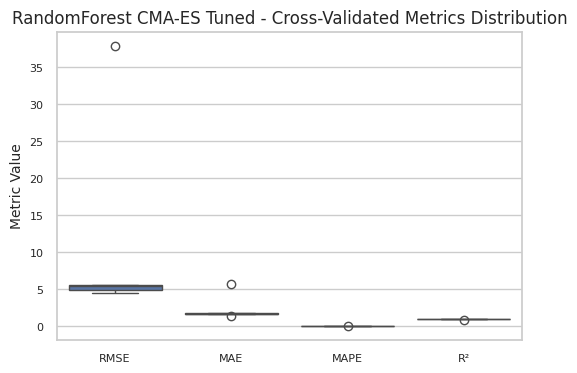

In [46]:
# Evaluate the CMA-ES tuned model using cross-validation on the test set
evaluation_results_tuned_cma = evaluate_models_cross_validated(
    {f'{best_model_name} CMA-ES Tuned': models[f'{best_model_name} CMA-ES Tuned']},
    X_test,
    y_test,
    cv_splits=5
)

===== Evaluating RandomForest Optuna Tuned with Cross-Validation =====
Cross-Validated RMSE: 11.63
Cross-Validated RMSE Std: 13.13
Cross-Validated MAE: 2.38
Cross-Validated MAE Std: 1.64
Cross-Validated MAPE: 0.04
Cross-Validated MAPE Std: 0.01
Cross-Validated R²: 0.97
Cross-Validated R² Std: 0.05




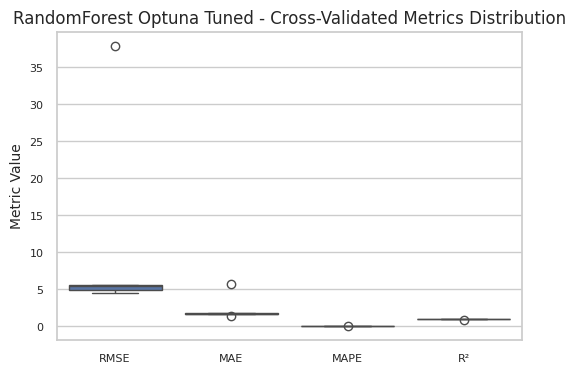

In [47]:
# Evaluate the Optuna tuned model using cross-validation on the test set
evaluation_results_tuned_optuna = evaluate_models_cross_validated(
    {f'{best_model_name} Optuna Tuned': models[f'{best_model_name} Optuna Tuned']},
    X_test,
    y_test,
    cv_splits=5
)

===== Evaluating RandomForest GA Tuned with Cross-Validation =====
Cross-Validated RMSE: 11.63
Cross-Validated RMSE Std: 13.13
Cross-Validated MAE: 2.38
Cross-Validated MAE Std: 1.64
Cross-Validated MAPE: 0.04
Cross-Validated MAPE Std: 0.01
Cross-Validated R²: 0.97
Cross-Validated R² Std: 0.05




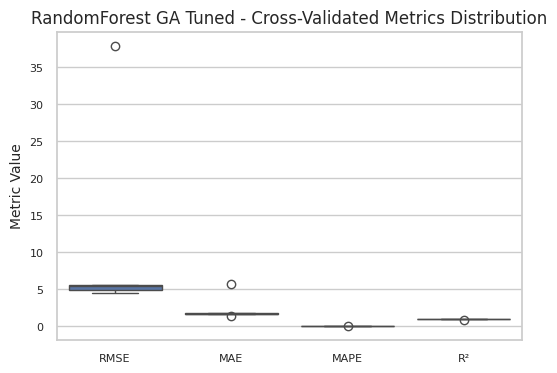

In [48]:
# Evaluate the GA tuned model using cross-validation on the test set
evaluation_results_tuned_ga = evaluate_models_cross_validated(
    {f'{best_model_name} GA Tuned': models[f'{best_model_name} GA Tuned']},
    X_test,
    y_test,
    cv_splits=5
)

In [49]:
def save_model(model_pipeline, model_path='model_pipeline.joblib', preprocessor_path='preprocessor.joblib'):
    """
    Save the trained model pipeline and preprocessor to disk.

    Parameters:
    - model_pipeline (Pipeline): Trained pipeline containing preprocessing and regressor.
    - model_path (str): File path to save the model.
    - preprocessor_path (str): File path to save the preprocessor.

    Returns:
    - None
    """
    # Save the entire pipeline (includes preprocessor and model)
    joblib.dump(model_pipeline, model_path)
    print(f"Model pipeline saved to {model_path}")

    # Extract and save the preprocessor separately if needed
    preprocessor = model_pipeline.named_steps['preprocessor']
    joblib.dump(preprocessor, preprocessor_path)
    print(f"Preprocessor saved to {preprocessor_path}")

In [50]:
# # Save the tuned models and preprocessors
# for tuning_method in ['CMA-ES', 'Optuna', 'GA']:
#     model_name = f'{best_model_name} {tuning_method} Tuned'
#     model_pipeline = models.get(model_name, None)
#     if model_pipeline:
#         model_file = f"{model_name.replace(' ', '_').lower()}_pipeline.joblib"
#         preprocessor_file = f"preprocessor_{tuning_method.lower()}.joblib"
#         save_model(model_pipeline, model_path=model_file, preprocessor_path=preprocessor_file)
#         print("\n")
#     else:
#         print(f"Model '{model_name}' not found. Skipping save.")

In [51]:
def performance_comparison(evaluation_cma, evaluation_optuna, evaluation_ga):
    """
    Compare the performance of models tuned via CMA-ES, Optuna, and Genetic Algorithms.

    Parameters:
    - evaluation_cma (dict): Evaluation metrics from CMA-ES tuned model.
    - evaluation_optuna (dict): Evaluation metrics from Optuna tuned model.
    - evaluation_ga (dict): Evaluation metrics from Genetic Algorithm tuned model.

    Returns:
    - None
    """
    # Consolidate evaluation metrics
    comparison_df = pd.DataFrame({
        'CMA-ES Tuned': evaluation_cma[next(iter(evaluation_cma))],
        'Optuna Tuned': evaluation_optuna[next(iter(evaluation_optuna))],
        'GA Tuned': evaluation_ga[next(iter(evaluation_ga))]
    })

    # Transpose for better visualization
    comparison_df = comparison_df.transpose()

    print("===== Performance Comparison =====")
    display(comparison_df)
    print("\n")

    # Plotting the comparison
    comparison_df.plot(kind='bar', figsize=(7, 4))
    plt.title('Performance Comparison of Tuned Models')
    plt.ylabel('Metric Value')
    plt.xlabel('Tuning Method')
    plt.xticks(rotation=0)
    plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

===== Performance Comparison =====


,Cross-Validated RMSE,Cross-Validated RMSE Std,Cross-Validated MAE,Cross-Validated MAE Std,Cross-Validated MAPE,Cross-Validated MAPE Std,Cross-Validated R²,Cross-Validated R² Std
CMA-ES Tuned,11.627797,13.129459,2.377454,1.640911,0.036637,0.011467,0.967149,0.049855
Optuna Tuned,11.627797,13.129459,2.377454,1.640911,0.036637,0.011467,0.967149,0.049855
GA Tuned,11.627797,13.129459,2.377454,1.640911,0.036637,0.011467,0.967149,0.049855


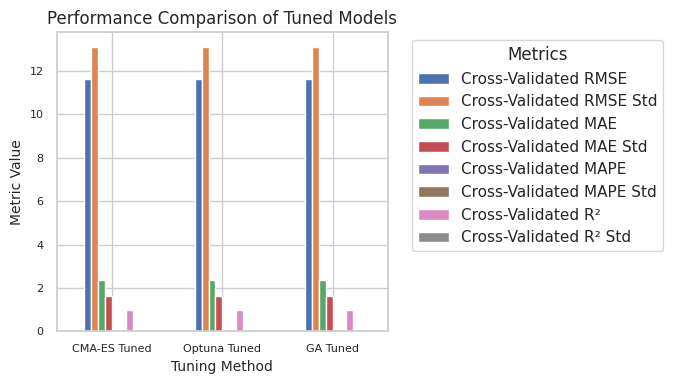

In [52]:
# Compare the performance of all tuned models
performance_comparison(
    evaluation_results_tuned_cma,
    evaluation_results_tuned_optuna,
    evaluation_results_tuned_ga
)

# Feature Importance

In [53]:
def plot_feature_importance(model_pipeline, feature_names, top_n=20):
    """
    Plot the feature importance for tree-based models.

    Parameters:
    - model_pipeline (Pipeline): Trained pipeline containing the regressor.
    - feature_names (list): List of feature names after preprocessing.
    - top_n (int): Number of top features to display.

    Returns:
    - None
    """
    # Extract the regressor from the pipeline
    regressor = model_pipeline.named_steps['regressor']

    # Check if model has feature_importances_
    if not hasattr(regressor, 'feature_importances_'):
        print(f"Model '{type(regressor).__name__}' does not have feature_importances_ attribute.")
        return

    # Get feature importances
    importances = regressor.feature_importances_

    # Create a DataFrame
    feat_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(6, 4))
    sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
    plt.title(f'Top {top_n} Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()
    print("\n")

===== Feature Importance for RandomForest CMA-ES Tuned =====


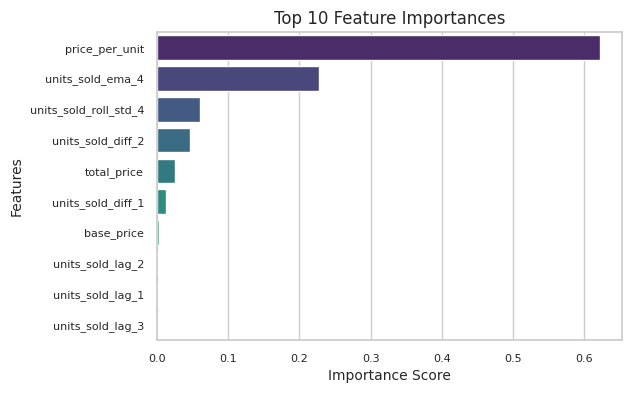



===== Feature Importance for RandomForest Optuna Tuned =====


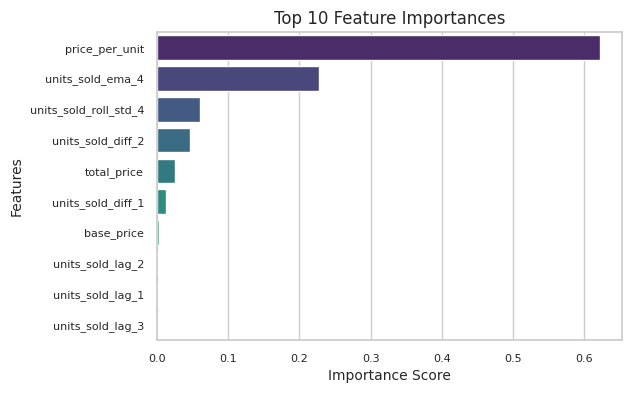



===== Feature Importance for RandomForest GA Tuned =====


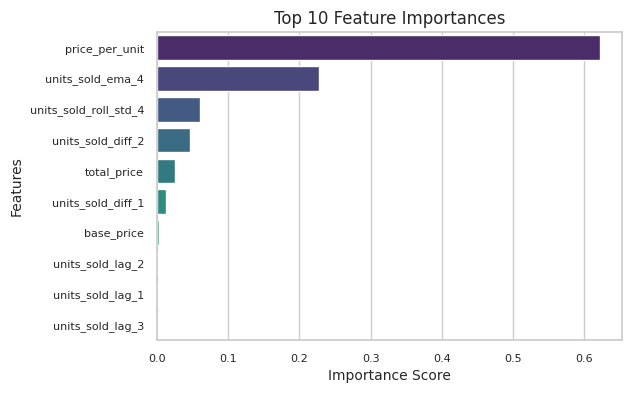

In [54]:
# Feature importance analysis for tuned models
tuned_models = [f'{best_model_name} CMA-ES Tuned',
               f'{best_model_name} Optuna Tuned',
               f'{best_model_name} GA Tuned']

for model_name in tuned_models:
    if model_name in models:
        print(f"===== Feature Importance for {model_name} =====")
        plot_feature_importance(models[model_name], feature_names, top_n=10)
    else:
        print(f"Model '{model_name}' not found in the models dictionary.")